# Using Stable Diffusion to generate dataset examples
We explore using a fine-tuned version of Stable Diffusion to generate examples of satellite images. Tested using SageMaker Studio, PyTorch 2.0 Python 3.10 GPU kernel on g4dn.xlarge.

In this tutorial, we go through using LoRA and Dreambooth to fine-tune Stable Diffusion, a text-to-image generation model, to generate additional satellite images to augment your dataset.

In [9]:
!nvidia-smi

Fri Jun  9 05:06:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install transformers accelerate>=0.16.0 ftfy tensorboard Jinja2 huggingface_hub wandb kaggle git+https://github.com/huggingface/diffusers

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-jgwy6eky


## Setup Kaggle
Follow the instructions [here](https://github.com/Kaggle/kaggle-api#api-credentials) to get your Kaggle credentials.

In [6]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
%%writefile /root/.kaggle/kaggle.json
{"username":"mithilcshah","key":""}

Overwriting /root/.kaggle/kaggle.json


In [8]:
!kaggle datasets download apollo2506/eurosat-dataset

eurosat-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


### Dataset
For this tutorial, we will use the EuroSAT dataset, which is a land use classification dataset consisting of Sentinel 2 Satellite images. We will use the `Highway` class as the type of satellite image that we would like to generate. The `Forest` and `Industrial` classes serve as the *class* that we want the model to separate the `Highway` *instance*. Check out the original [Dreambooth paper](https://dreambooth.github.io/) to find out more.

In [8]:
!mkdir -p EuroSAT/Highway
!unzip -q eurosat-dataset.zip "EuroSAT/Highway/*" -d ""

replace EuroSAT/Highway/Highway_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
!mkdir -p EuroSAT/base/Forest
!unzip -q eurosat-dataset.zip "EuroSAT/Forest/*" -d "base"

In [ ]:
!mkdir -p EuroSAT/base/Industrial
!unzip -q eurosat-dataset.zip "EuroSAT/Industrial/*" -d "base"

## View Dataset
Let's view the `Highway` class of the EuroSAT dataset

In [9]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

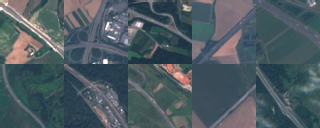

In [26]:
actual_img = [Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

Let's view the `Forest` and `Industrial` classes:

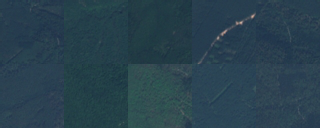

In [27]:
actual_img = [Image.open("base/EuroSAT/Forest/Forest_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

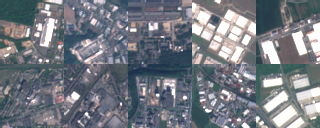

In [12]:
actual_img = [Image.open("base/EuroSAT/Industrial/Industrial_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

In [13]:
import shutil, os
forest_files = os.listdir("base/EuroSAT/Forest")
industrial_files = os.listdir("base/EuroSAT/Industrial")

In [14]:
!mkdir -p "base/class"

In [15]:
for filename in forest_files:
    shutil.copyfile(
        os.path.join("base/EuroSAT/Forest",filename),
        os.path.join("base/class",filename)
    )
for filename in industrial_files:
    shutil.copyfile(
        os.path.join("base/EuroSAT/Industrial",filename),
        os.path.join("base/class",filename)
    )

## Base model Stable Diffusion generation
Let's use Stable Diffusion (1.5) directly to generate satellite images of the `Highway` class. 

In [1]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*10, num_inference_steps=10).images

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [6]:
image_grid([x.resize((128,128)) for x in img_list], 2,5)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_907/2155384033.py:1 in <module>                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_907/2155384033.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'image_grid' is not defined

In [8]:
import gc
from numba import cuda
del(pipe)
gc.collect()
torch.cuda.empty_cache()

device = cuda.get_current_device()
device.reset()

## Actual highway class images

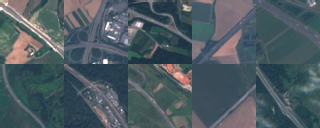

In [20]:
actual_img = [Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)

We see that in terms of color and style there is a significant difference between Stable Diffusion direct generated images and the actual EuroSAT dataset images

## Fine-tune Stable Diffusion with LORA and DreamBooth
We want to fine-tune our text-to-image model to learn how to generate the right type of satellite images. To do so, we utilize two recent innovations, Dreambooth and LoRA. Dreambooth is a new method to allow models to learn to generate images that fit the distinct characteristics of the `instance` relative to the larger `class`. Low rank adapters (LoRA) allows for fast model training by drastically reducing the number of training parameters. We utilize the scripts found [here](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README.md).

In [21]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

--2023-06-09 02:31:35--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57483 (56K) [text/plain]
Saving to: ‘train_dreambooth_lora.py’

train_dreambooth_lo 100%[===================>]  56.14K  --.-KB/s    in 0s      

2023-06-09 02:31:36 (122 MB/s) - ‘train_dreambooth_lora.py’ saved [57483/57483]



In [10]:
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="EuroSAT/Highway" \
  --output_dir=trained_model \
  --instance_prompt="Sentinel 2 satellite image of sks" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="tensorboard" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --with_prior_preservation \
  --class_data_dir="base/class" \
  --class_prompt="Sentinel 2 satellite image" \
  --max_train_steps=1000 \
  --seed="0" \
  --mixed_precision="fp16"

[05:07:00] WARNING  The following values were not passed to        ]8;id=788118;file:///opt/conda/lib/python3.10/site-packages/accelerate/commands/launch.py\launch.py]8;;\:]8;id=870350;file:///opt/conda/lib/python3.10/site-packages/accelerate/commands/launch.py#890\890]8;;\
                    `accelerate launch` and had defaults used                   
                    instead:                                                    
                            `--num_processes` was set to a value                
                    of `1`                                                      
                            `--num_machines` was set to a value of              
                    `1`                                                         
                            `--mixed_precision` was set to a value              
                    of `'no'`                                                   
                            `--dynamo_backend` was set to a value    

## Visualizing results
Now that the model is trained, let's compare:
1. Stable Diffusion generated images without fine-tuning
2. Stable Diffusion generated images with LoRA and Dreambooth fine-tuning
3. Original EuroSAT images

In [5]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.18.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [8]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


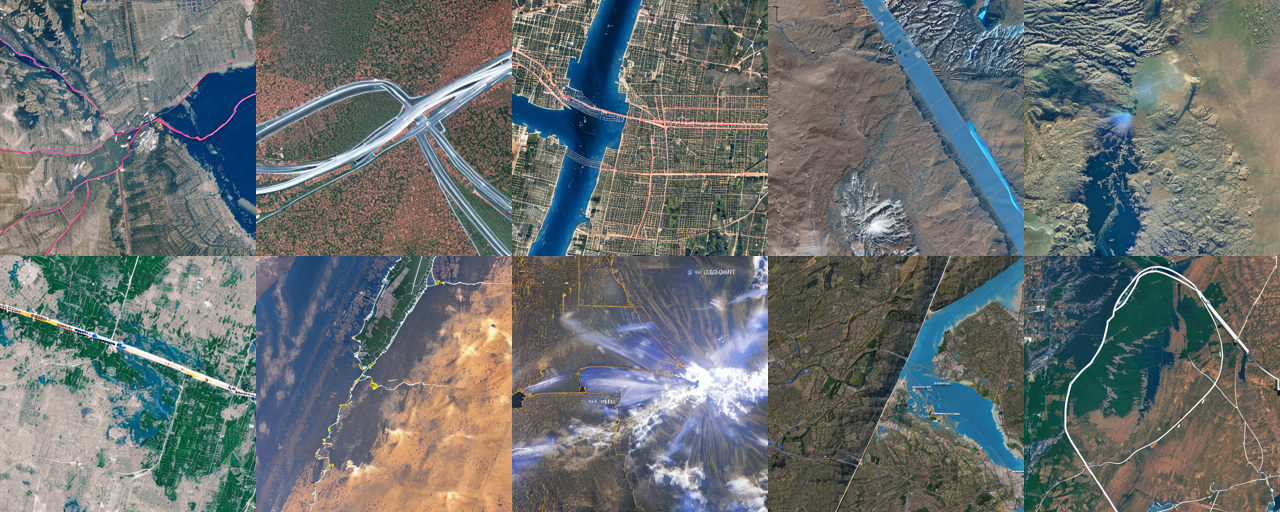

In [10]:
img_list = pipe(["Sentinel 2 satellite image of a highway"]*10, num_inference_steps=25).images
image_grid([x.resize((256,256)) for x in img_list], 2,5)

In [11]:
pipe.unet.load_attn_procs("./trained_model/checkpoint-800")

In [12]:
img_list = pipe(["Sentinel 2 satellite image of sks"]*10, num_inference_steps=25).images

100%|██████████| 25/25 [00:32<00:00,  1.30s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


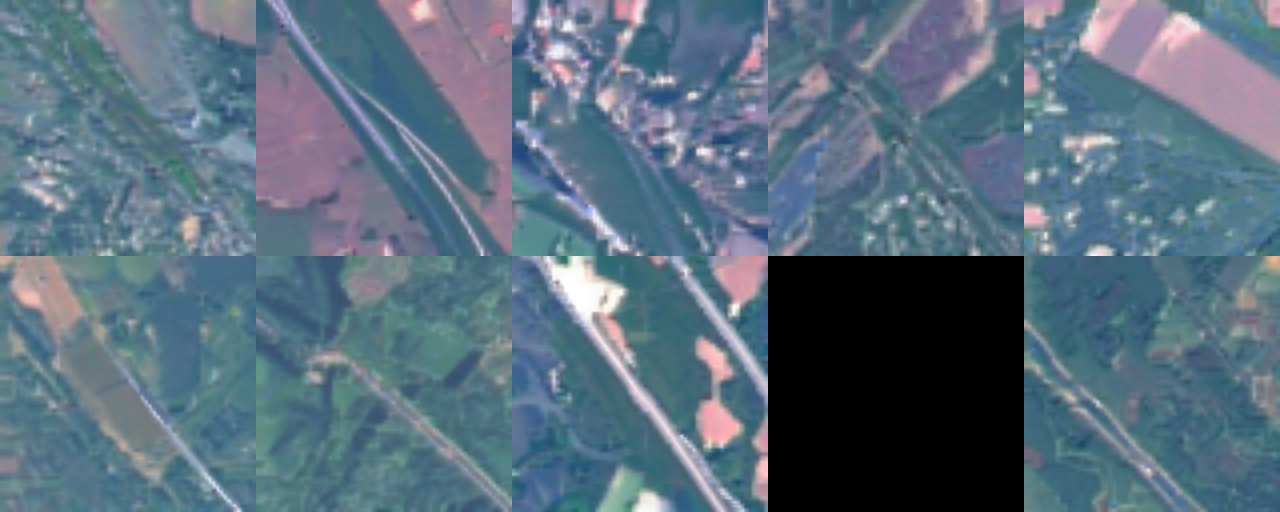

In [13]:
image_grid([x.resize((256,256)) for x in img_list], 2,5)

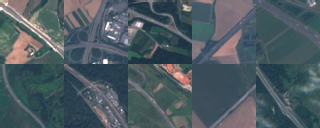

In [14]:
from PIL.ImageOps import exif_transpose
actual_img = [exif_transpose(Image.open("EuroSAT/Highway/Highway_{}.jpg".format(str(i)))) for i in range(1,11)]
image_grid([x.resize((64,64)) for x in actual_img], 2,5)